### 1. Importing Libraries

In [1]:
# Importing necessary libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Importing libraries for natural language processing (NLP)
import string
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('stopwords')

# Importing libraries for machine learning and model evaluation
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Setting display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Suppressing warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AyseDuman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AyseDuman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data

path = "."
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

print (train.shape, test.shape)

(7613, 5) (3263, 4)


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#    1. Expalanatory Data Analysis

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

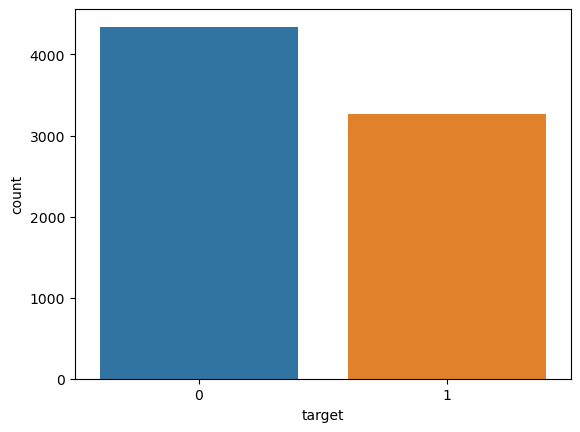

In [7]:
sns.countplot(train["target"])

#### 1.1 Most common words in the corpus

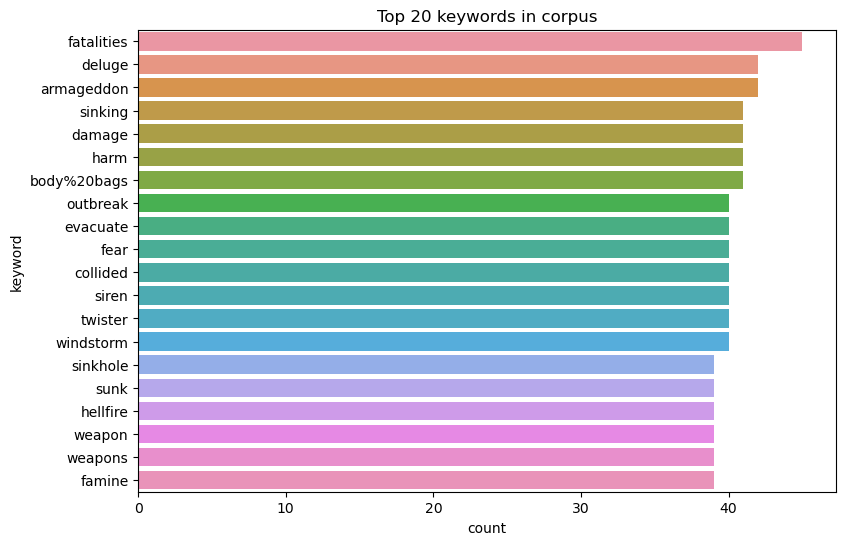

In [15]:
plt.figure(figsize = (9,6))
sns.countplot(y = train.keyword, order = train.keyword.value_counts().iloc[:20].index)
plt.title("Top 20 keywords in corpus")
plt.show()

#### 1.2 Top  words in disaster and non-disaster tweets

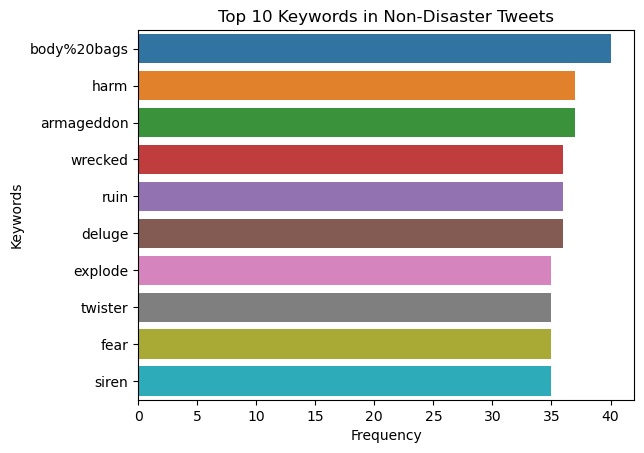

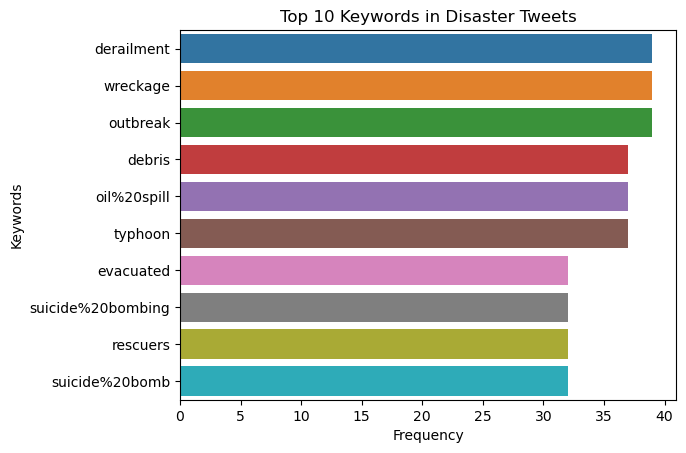

In [9]:
# top 10 keywords in non-disaster and disaster tweets
train_nd_kw = train[train.target == 0].keyword.value_counts().head(10)
train_d_kw = train[train.target == 1].keyword.value_counts().head(10)

# Plot the top 10 keywords in non-disaster tweets
sns.barplot(train_nd_kw, train_nd_kw.index)
plt.title("Top 10 Keywords in Non-Disaster Tweets")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.show()

# Plot the top 10 keywords in disaster tweets
sns.barplot(train_d_kw, train_d_kw.index)
plt.title("Top 10 Keywords in Disaster Tweets")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.show()


In [10]:
import pandas as pd

# Get the top 10 keywords in non-disaster tweets
train_nd_kw = train[train.target == 0].keyword.value_counts().head(10)
non_disaster_keywords_df = pd.DataFrame({
    'Non-Disaster Keywords': train_nd_kw.index,
    'Frequency': train_nd_kw.values
})

# Get the top 10 keywords in disaster tweets
train_d_kw = train[train.target == 1].keyword.value_counts().head(10)
disaster_keywords_df = pd.DataFrame({
    'Disaster Keywords': train_d_kw.index,
    'Frequency': train_d_kw.values
})

# Display the DataFrames
print("Top 10 Keywords in Non-Disaster Tweets:")
print(non_disaster_keywords_df)
print("\nTop 10 Keywords in Disaster Tweets:")
print(disaster_keywords_df)


Top 10 Keywords in Non-Disaster Tweets:
  Non-Disaster Keywords  Frequency
0           body%20bags         40
1                  harm         37
2            armageddon         37
3               wrecked         36
4                  ruin         36
5                deluge         36
6               explode         35
7               twister         35
8                  fear         35
9                 siren         35

Top 10 Keywords in Disaster Tweets:
   Disaster Keywords  Frequency
0         derailment         39
1           wreckage         39
2           outbreak         39
3             debris         37
4        oil%20spill         37
5            typhoon         37
6          evacuated         32
7  suicide%20bombing         32
8           rescuers         32
9     suicide%20bomb         32


#### 1.3 Most common locations in real disaster twitter dataset

Top 10 Countries in Real Disaster Tweets:
United States     235
United Kingdom     41
India              39
Nigeria            22
Canada             20
Worldwide          12
Australia           9
Unknown             9
Indonesia           8
Ireland             6
Name: location, dtype: int64


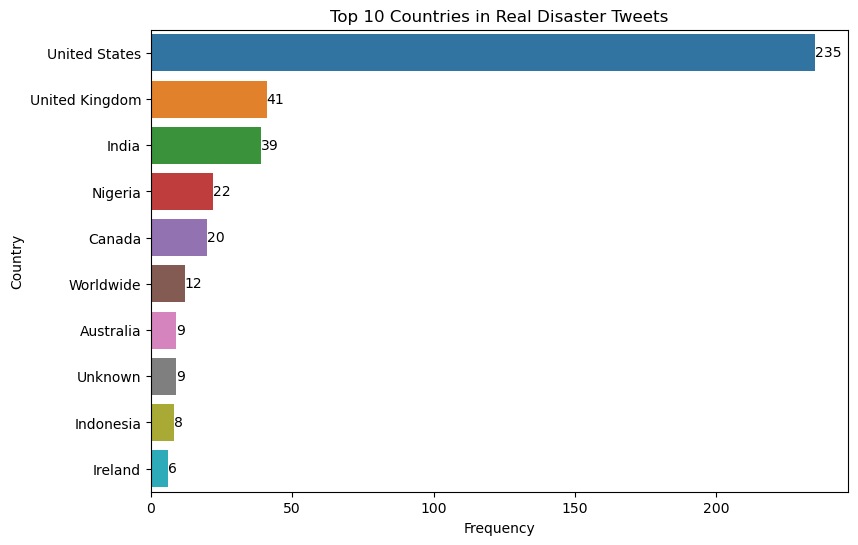

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset for disaster tweets
train_d = train[train.target == 1]

# Define a mapping of locations to unify similar ones and to map cities to their countries
location_mapping = {
    'USA': 'United States',
    'United States': 'United States',
    'San Francisco' : 'United States',
    'UK': 'United Kingdom',
    'London':  'United Kingdom',
    'Washington, DC': 'United States',
    'Washington, D.C.': 'United States',
    'Chicago, IL': 'United States',
    'New York': 'United States',
    'Los Angeles, CA': 'United States',
    'California, USA': 'United States',
    'Los Angeles': 'United States',
    'Nashville, TN': 'United States',
    'Earth': 'Unknown',
    'California': 'United States',
    'Mumbai': 'India',
    'Toronto': 'Canada',
    'Sacramento, CA': 'United States',
    'New York, NY': 'United States',
    'New York City': 'United States',
    'Denver, Colorado': 'United States',
    'San Francisco, CA ':'United States',
    'US': 'United States',
    'San Francisco, CA': 'United States',
    'Oklahoma City, OK': 'United States',
    'Atlanta, GA': 'United States',
    'London, UK': 'United Kingdom',
    
}

# Apply the mapping to the location column
train_d['location'] = train_d['location'].map(location_mapping).fillna(train_d['location'])

# Get the top 10 locations in the disaster dataset
top_locations = train_d.location.value_counts().iloc[:10]

# Print the top 10 locations and their frequencies
print("Top 10 Countries in Real Disaster Tweets:")
print(top_locations)

# Plot the top 10 locations in the real disaster dataset
plt.figure(figsize=(9,6))
sns.countplot(y=train_d.location, order=top_locations.index)
plt.title('Top 10 Countries in Real Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Country')

# Annotate the plot with the values
for index, value in enumerate(top_locations.values):
    plt.text(value, index, str(value), va='center')

plt.show()


#### 1.4 Most common locations in not real disaster twitter dataset

Top 10 Countries in Fake Disaster Tweets:
United States     271
Unknown            38
United Kingdom     37
London             29
Canada             21
Kenya              15
Australia           9
Japan               7
South Africa        6
Ireland             6
Name: location, dtype: int64


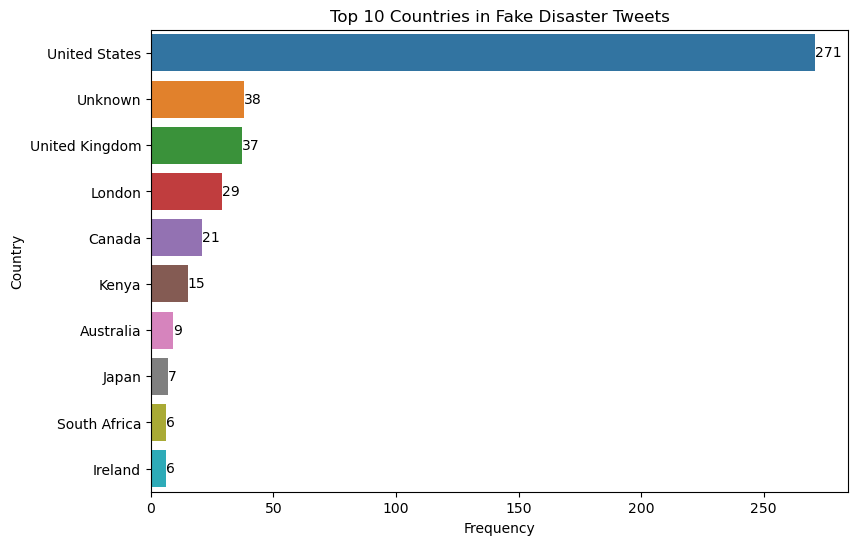

In [12]:
train_n = train[train.target==0]


location_mapping = {
    'USA': 'United States',
    'United States': 'United States',
    'UK': 'United Kingdom',
    'Washington, DC': 'United States',
    'Washington, D.C.': 'United States',
    'Chicago, IL': 'United States',
    'New York': 'United States',
    'Los Angeles, CA': 'United States',
    'California, USA': 'United States',
    'Los Angeles': 'United States',
    'Nashville, TN': 'United States',
    'San Francisco, CA': 'United States',
    'Toronto': 'Canada',
    'Sacramento, CA': 'United States',
    'New York, NY': 'United States',
    'New York City': 'United States',
    'Denver, Colorado': 'United States',
    'US': 'United States',
    'ss': 'Unknown',
    'NYC': 'United States',
    'Florida': 'United States',
    'San Francisco': 'United States',
    'Everywhere': 'Unknown',
    'Worldwide': 'Unknown',
    '304':'Unknown',
    'London, England':  'United Kingdom',
    'Seattle':'United States',
    'Texas':'United States',
    'Chicago': 'United States',
    'California': 'United States',
    'Dallas, TX': 'United States',
    'Pennsylvania, USA': 'United States',
    'Manchester':'United Kingdom',
    'San Diego, CA':'United States',
    'Morioh, Japan' : 'Japan'
    
}

# Apply the mapping to the location column
train_n['location'] = train_n['location'].map(location_mapping).fillna(train_n['location'])

# Get the top 10 locations in the disaster dataset
top_locations = train_n.location.value_counts().iloc[:10]

# Print the top 10 locations and their frequencies
print("Top 10 Countries in Fake Disaster Tweets:")
print(top_locations)

# Plot the top 10 locations in the real disaster dataset
plt.figure(figsize=(9,6))
sns.countplot(y=train_n.location, order=top_locations.index)
plt.title('Top 10 Countries in Fake Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Country')

# Annotate the plot with the values
for index, value in enumerate(top_locations.values):
    plt.text(value, index, str(value), va='center')

plt.show()


# 2. Data Preprocessing (eklendi)

In [13]:
# text_processing.py

location_mapping = {
    'USA': 'United States',
    'United States': 'United States',
    'San Francisco': 'United States',
    'UK': 'United Kingdom',
    'London': 'United Kingdom',
    'Washington, DC': 'United States',
    'Washington, D.C.': 'United States',
    'Chicago, IL': 'United States',
    'New York': 'United States',
    'Los Angeles, CA': 'United States',
    'California, USA': 'United States',
    'Los Angeles': 'United States',
    'Nashville, TN': 'United States',
    'Earth': 'Unknown',
    'California': 'United States',
    'Mumbai': 'India',
    'Toronto': 'Canada',
    'Sacramento, CA': 'United States',
    'New York, NY': 'United States',
    'New York City': 'United States',
    'Denver, Colorado': 'United States',
    'San Francisco, CA ': 'United States',
    'US': 'United States',
    'San Francisco, CA': 'United States',
    'Oklahoma City, OK': 'United States',
    'Atlanta, GA': 'United States',
    'London, UK': 'United Kingdom',
    'ss': 'Unknown',
    'NYC': 'United States',
    'Florida': 'United States',
    'Everywhere': 'Unknown',
    'Worldwide': 'Unknown',
    '304': 'Unknown',
    'London, England': 'United Kingdom',
    'Seattle': 'United States',
    'Texas': 'United States',
    'Chicago': 'United States',
    'Dallas, TX': 'United States',
    'Pennsylvania, USA': 'United States',
    'Manchester': 'United Kingdom',
    'San Diego, CA': 'United States',
    'Morioh, Japan': 'Japan'
}


# Function to map locations in a DataFrame using the provided mapping dictionary
def map_locations(df, location_mapping):
    # Apply the mapping to the location column
    df['location'] = df['location'].map(location_mapping).fillna(df['location'])
    return df



def clean_text(text):
    # Remove line breaks
    text = re.sub(r'\n', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags 
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove special characters and punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove dollar signs and other special symbols
    text = re.sub(r'\$\w*', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word.lower() not in stop_words])
    return text


def extract_entities(tweet):
    hashtags = " ".join(re.findall(r"#(\w+)", tweet)) or 'no'
    mentions = " ".join(re.findall(r"@(\w+)", tweet)) or 'no'
    links = 'yes' if re.search(r"https?://\S+", tweet) else 'no'
    numbers = 'yes' if re.search(r'\b\d+\b', tweet) else 'no'
    time = 'yes' if re.search(r'\b\d{1,2}:\d{2}(?::\d{2})?\b', tweet) else 'no'
    rt = 'yes' if re.search(r'\bRT\b', tweet) else 'no'
    return hashtags, mentions, links, numbers, time, rt


def process_text(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df[['hashtags', 'mentions', 'links', 'numbers', 'time', 'rt']] = df['text'].apply(lambda x: pd.Series(extract_entities(x)))
    return df





In [14]:
train = map_locations(train, location_mapping)

train = process_text(train)

In [17]:
import pandas as pd
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree



def extract_named_entities(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    entities = {'people': [], 'organizations': [], 'locations': []}
    current_chunk = []
    for subtree in chunked:
        if type(subtree) == Tree:
            if subtree.label() == 'GPE':
                locations = [token for token, pos in subtree.leaves()]
                entities['locations'].append(" ".join(locations))
            elif subtree.label() == 'ORGANIZATION':
                organizations = [token for token, pos in subtree.leaves()]
                entities['organizations'].append(" ".join(organizations))
            elif subtree.label() == 'PERSON':
                people = [token for token, pos in subtree.leaves()]
                entities['people'].append(" ".join(people))
                
    return entities



# new columns for people, organizations, and locations
entities = train['text_clean'].apply(extract_named_entities).apply(pd.Series)
train = pd.concat([train, entities], axis=1)

train


,id,keyword,location,text,target,text_clean,hashtags,mentions,links,numbers,time,rt,people,organizations,locations
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Deeds Reason earthquake May ALLAH Forgive us,earthquake,no,no,no,no,no,"[Deeds, Reason]",[],[]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,no,no,no,no,no,no,[La Ronge Sask Canada],[],[Forest]
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,no,no,no,no,no,no,[],[],[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders California,wildfires,no,no,yes,no,no,[],[],[California]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo Ruby Alaska smoke wildfires pours school,Alaska wildfires,no,no,no,no,no,[Ruby Alaska],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding bridge collapse nearby homes,no,no,yes,no,no,no,[],[],[]
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,control wild fires California even Northern part state troubling,no,aria_ahrary TheTawniest,no,no,no,no,[],[],"[California, Northern]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,M194 0104 UTC5km Volcano Hawaii,no,no,yes,yes,yes,no,[],[UTC5km Volcano Hawaii],[]
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating ebike collided car Little Portugal Ebike rider suffered serious nonlife threatening injuries,no,no,no,no,no,no,[],[],[Portugal]


### 3.. FEATURE ENGINEERING AND DATA CLEANING

In [11]:
#!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org wordcloud

In [12]:
import re
from wordcloud import STOPWORDS


In [18]:
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))


def textual_feature_generation(df):
    df["text_len"] = df["text_clean"].astype(str).apply(len)  # length of tweet
    df["ratio_of_capital_letters"] = df["text_clean"].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(x) if len(x) > 0 else 0)
    df['number_of_words'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    df["number_of_characters_from_cleaned_text"] = df["text_clean"].apply(lambda x: len(str(x)))
    df["number_of_characters_from_text"] = df["text"].apply(lambda x: len(str(x)))
    df["number_of_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df["number_of_punctuation"] = df["text_clean"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df["number_of_hashtags"] = df["hashtags"].apply(lambda x: len(str(x).split()) if x != "no" else 0)
    df["number_of_mentions"] = df["mentions"].apply(lambda x: len(str(x).split()) if x != "no" else 0)
    df["number_of_links"] = df["links"].apply(lambda x: 1 if x == 'yes' else 0)
    
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AyseDuman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

train_full = textual_feature_generation(train)
train_full

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AyseDuman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,text_clean,hashtags,mentions,links,numbers,time,rt,people,organizations,locations,text_len,ratio_of_capital_letters,number_of_words,number_of_characters_from_cleaned_text,number_of_characters_from_text,number_of_stopwords,number_of_punctuation,number_of_hashtags,number_of_mentions,number_of_links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Deeds Reason earthquake May ALLAH Forgive us,earthquake,no,no,no,no,no,"[Deeds, Reason]",[],[],44,0.204545,7,44,69,6,0,1,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,no,no,no,no,no,no,[La Ronge Sask Canada],[],[Forest],37,0.135135,7,37,38,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,no,no,no,no,no,no,[],[],[],88,0.000000,11,88,133,11,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders California,wildfires,no,no,yes,no,no,[],[],[California],59,0.016949,7,59,65,1,0,1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo Ruby Alaska smoke wildfires pours school,Alaska wildfires,no,no,no,no,no,[Ruby Alaska],[],[],55,0.036364,9,55,88,7,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding bridge collapse nearby homes,no,no,yes,no,no,no,[],[],[],53,0.018868,8,53,83,2,0,0,0,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,control wild fires California even Northern part state troubling,no,aria_ahrary TheTawniest,no,no,no,no,[],[],"[California, Northern]",64,0.031250,9,64,125,9,0,0,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,M194 0104 UTC5km Volcano Hawaii,no,no,yes,yes,yes,no,[],[UTC5km Volcano Hawaii],[],31,0.193548,5,31,65,2,0,0,0,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating ebike collided car Little Portugal Ebike rider suffered serious nonlife threatening injuries,no,no,no,no,no,no,[],[],[Portugal],113,0.035398,14,113,137,5,0,0,0,0


In [30]:
def remove_words(text, words_to_remove):
    """
    Remove specified words from the text.

    Args:
    - text (str): The input text.
    - words_to_remove (list): A list of words to be removed.

    Returns:
    - str: The text with specified words removed.
    """
    return ' '.join([word for word in text.split() if word.lower() not in words_to_remove])

# Define the words to remove
words_to_remove = ['im', 'mh370', 'via']

# Apply the function to the 'text_clean' column of train_full DataFrame
train_full['text_clean'] = train_full['text_clean'].apply(lambda x: remove_words(x, words_to_remove))



import pandas as pd
import numpy as np

def update_location(row):
    """
    Update the 'location' value for a single row based on the 'locations' value.

    Args:
    row (pd.Series): A single row of the DataFrame.

    Returns:
    str: Updated 'location' value for the row.
    """
    if pd.isna(row['location']) and isinstance(row['locations'], list):
        # Join the list of locations into a single string separated by commas
        return ', '.join(row['locations'])
    return row['location']

# Apply the update_location function to each row in the DataFrame
train_full['location'] = train_full.apply(update_location, axis=1)




In [38]:
def update_people(row):
    """
    Update the 'people' value for a single row based on the 'people' value.
    
    Args:
    row (pd.Series): A single row of the DataFrame.
    
    Returns:
    str: Updated 'people' value for the row.
    """
    if isinstance(row['people'], list) and len(row['people']) > 0:
        # Join the list of people into a single string separated by commas
        return ', '.join(row['people'])
    elif isinstance(row['people'], list) and len(row['people']) == 0:
        return np.nan
    return row['people']

def update_organizations(row):
    """
    Update the 'organizations' value for a single row based on the 'organizations' value.
    
    Args:
    row (pd.Series): A single row of the DataFrame.
    
    Returns:
    str: Updated 'organizations' value for the row.
    """
    if isinstance(row['organizations'], list) and len(row['organizations']) > 0:
        # Join the list of organizations into a single string separated by commas
        return ', '.join(row['organizations'])
    elif isinstance(row['organizations'], list) and len(row['organizations']) == 0:
        return np.nan
    return row['organizations']



# Apply the update_organizations function to each row in the DataFrame
train_full['organizations'] = train_full.apply(update_organizations, axis=1)


train_full['people'] = train_full.apply(update_people, axis=1)


In [21]:
# -*- coding: utf-8 -*-
"""
DATA PROCESSING 
@author: AyseDuman
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def lda_topic_modelling(data, text_column, n_topics=10, n_top_words=1, max_features=5000):
    """
    Perform LDA topic modeling and add topic-related features to the dataframe.
    
    Args:
    - data (pd.DataFrame): DataFrame containing the text data.
    - text_column (str): Name of the column containing text data.
    - n_topics (int): Number of topics to generate.
    - n_top_words (int): Number of top words to extract for each topic.
    - max_features (int): Maximum number of features for the TF-IDF vectorizer.
    
    Returns:
    - pd.DataFrame: DataFrame with added topic-related features.
    """
    # TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(data[text_column])

    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    # Function to get top words for each topic
    def get_top_words(model, feature_names, n_top_words):
        top_words = {}
        for topic_idx, topic in enumerate(model.components_):
            top_words[f"topic_{topic_idx}"] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        return top_words

    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    top_words = get_top_words(lda, feature_names, n_top_words)

    print("Top words for each topic:")
    for topic, words in top_words.items():
        print(f"{topic}: {', '.join(words)}")

    # Assign topics to tweets based on the highest topic probability
    topic_distribution = lda.transform(X)
    data['dominant_topic'] = topic_distribution.argmax(axis=1)

    # Add top words of the dominant topic as features
    for i in range(n_top_words):
        data[f'topic_word_{i}'] = data['dominant_topic'].apply(lambda topic: top_words[f'topic_{topic}'][i])

    return data


# Apply the LDA topic modeling function
train_full = lda_topic_modelling(train_full, text_column='text_clean', n_topics=10, n_top_words=1, max_features=5000)




Top words for each topic:
topic_0: california
topic_1: screaming
topic_2: hiroshima
topic_3: body
topic_4: crush
topic_5: good
topic_6: accident
topic_7: emergency
topic_8: fire
topic_9: legionnaires


In [39]:
# Display the resulting DataFrame
train_full

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,numbers,time,rt,people,organizations,locations,text_len,ratio_of_capital_letters,number_of_words,number_of_characters_from_cleaned_text,number_of_characters_from_text,number_of_stopwords,number_of_punctuation,number_of_hashtags,number_of_mentions,number_of_links,dominant_topic,topic_word_0,neg,neu,pos,compound
0,1,NaN,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Deeds Reason earthquake May ALLAH Forgive us,earthquake,no,no,no,no,no,"Deeds, Reason",NaN,[],44,0.204545,7,44,69,6,0,1,0,0,9,legionnaires,0.000,0.741,0.259,0.2732
1,4,NaN,Forest,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,no,no,no,no,no,no,La Ronge Sask Canada,NaN,[Forest],37,0.135135,7,37,38,0,0,0,0,0,4,crush,0.286,0.714,0.000,-0.3400
2,5,NaN,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,no,no,no,no,no,no,NaN,NaN,[],88,0.000000,11,88,133,11,0,0,0,0,5,good,0.000,1.000,0.000,0.0000
3,6,NaN,California,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders California,wildfires,no,no,yes,no,no,NaN,NaN,[California],59,0.016949,7,59,65,1,0,1,0,0,0,california,0.000,1.000,0.000,0.0000
4,7,NaN,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo Ruby Alaska smoke wildfires pours school,Alaska wildfires,no,no,no,no,no,Ruby Alaska,NaN,[],55,0.036364,9,55,88,7,0,2,0,0,3,body,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding bridge collapse nearby homes,no,no,yes,no,no,no,NaN,NaN,[],53,0.018868,8,53,83,2,0,0,0,1,6,accident,0.314,0.686,0.000,-0.4939
7609,10870,NaN,"California, Northern",@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,control wild fires California even Northern part state troubling,no,aria_ahrary TheTawniest,no,no,no,no,NaN,NaN,"[California, Northern]",64,0.031250,9,64,125,9,0,0,2,0,0,california,0.304,0.696,0.000,-0.5423
7610,10871,NaN,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,M194 0104 UTC5km Volcano Hawaii,no,no,yes,yes,yes,no,NaN,UTC5km Volcano Hawaii,[],31,0.193548,5,31,65,2,0,0,0,1,9,legionnaires,0.000,1.000,0.000,0.0000
7611,10872,NaN,Portugal,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating ebike collided car Little Portugal Ebike rider suffered serious nonlife threatening injuries,no,no,no,no,no,no,NaN,NaN,[Portugal],113,0.035398,14,113,137,5,0,0,0,0,9,legionnaires,0.418,0.582,0.000,-0.7845


In [23]:
# Import necessary libraries

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Ensure the VADER lexicon is downloaded
nltk.download('vader_lexicon')


# Function to apply VADER sentiment analysis on a DataFrame
def apply_vader_sentiment_analysis(df, text_column):
    """
    Applies VADER sentiment analysis to a specified text column in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing the text data.
        text_column (str): The name of the column in the DataFrame that contains the text to analyze.

    Returns:
        pd.DataFrame: The original DataFrame with additional columns for sentiment scores:
                      'neg', 'neu', 'pos', and 'compound'.
    """
    # Initialize the VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Function to get sentiment scores for a given text
    def get_sentiment_scores(text):
        """
        Computes sentiment scores for a given text using VADER sentiment analysis.

        Args:
            text (str): The text to analyze.

        Returns:
            tuple: A tuple containing the negative, neutral, positive, and compound sentiment scores.
        """
        scores = sid.polarity_scores(text)
        return scores['neg'], scores['neu'], scores['pos'], scores['compound']

    # Apply sentiment analysis to the specified text column and create new columns for the scores
    df['neg'], df['neu'], df['pos'], df['compound'] = zip(*df[text_column].map(get_sentiment_scores))

    return df

# Example usage:
train_full = apply_vader_sentiment_analysis(train_full, 'text_clean')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AyseDuman\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
train_full

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,numbers,time,rt,people,organizations,locations,text_len,ratio_of_capital_letters,number_of_words,number_of_characters_from_cleaned_text,number_of_characters_from_text,number_of_stopwords,number_of_punctuation,number_of_hashtags,number_of_mentions,number_of_links,dominant_topic,topic_word_0,neg,neu,pos,compound
0,1,NaN,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Deeds Reason earthquake May ALLAH Forgive us,earthquake,no,no,no,no,no,"[Deeds, Reason]",[],[],44,0.204545,7,44,69,6,0,1,0,0,9,legionnaires,0.000,0.741,0.259,0.2732
1,4,NaN,Forest,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,no,no,no,no,no,no,[La Ronge Sask Canada],[],[Forest],37,0.135135,7,37,38,0,0,0,0,0,4,crush,0.286,0.714,0.000,-0.3400
2,5,NaN,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,no,no,no,no,no,no,[],[],[],88,0.000000,11,88,133,11,0,0,0,0,5,good,0.000,1.000,0.000,0.0000
3,6,NaN,California,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders California,wildfires,no,no,yes,no,no,[],[],[California],59,0.016949,7,59,65,1,0,1,0,0,0,california,0.000,1.000,0.000,0.0000
4,7,NaN,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo Ruby Alaska smoke wildfires pours school,Alaska wildfires,no,no,no,no,no,[Ruby Alaska],[],[],55,0.036364,9,55,88,7,0,2,0,0,3,body,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding bridge collapse nearby homes,no,no,yes,no,no,no,[],[],[],53,0.018868,8,53,83,2,0,0,0,1,6,accident,0.314,0.686,0.000,-0.4939
7609,10870,NaN,"California, Northern",@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,control wild fires California even Northern part state troubling,no,aria_ahrary TheTawniest,no,no,no,no,[],[],"[California, Northern]",64,0.031250,9,64,125,9,0,0,2,0,0,california,0.304,0.696,0.000,-0.5423
7610,10871,NaN,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,M194 0104 UTC5km Volcano Hawaii,no,no,yes,yes,yes,no,[],[UTC5km Volcano Hawaii],[],31,0.193548,5,31,65,2,0,0,0,1,9,legionnaires,0.000,1.000,0.000,0.0000
7611,10872,NaN,Portugal,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating ebike collided car Little Portugal Ebike rider suffered serious nonlife threatening injuries,no,no,no,no,no,no,[],[],[Portugal],113,0.035398,14,113,137,5,0,0,0,0,9,legionnaires,0.418,0.582,0.000,-0.7845


# 4.Train and Test Splitting

In [37]:
train_full.head(10)

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,numbers,time,rt,people,organizations,locations,text_len,ratio_of_capital_letters,number_of_words,number_of_characters_from_cleaned_text,number_of_characters_from_text,number_of_stopwords,number_of_punctuation,number_of_hashtags,number_of_mentions,number_of_links,dominant_topic,topic_word_0,neg,neu,pos,compound
0,1,NaN,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Deeds Reason earthquake May ALLAH Forgive us,earthquake,no,no,no,no,no,"Deeds, Reason",[],[],44,0.204545,7,44,69,6,0,1,0,0,9,legionnaires,0.000,0.741,0.259,0.2732
1,4,NaN,Forest,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,no,no,no,no,no,no,La Ronge Sask Canada,[],[Forest],37,0.135135,7,37,38,0,0,0,0,0,4,crush,0.286,0.714,0.000,-0.3400
2,5,NaN,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,no,no,no,no,no,no,[],[],[],88,0.000000,11,88,133,11,0,0,0,0,5,good,0.000,1.000,0.000,0.0000
3,6,NaN,California,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders California,wildfires,no,no,yes,no,no,[],[],[California],59,0.016949,7,59,65,1,0,1,0,0,0,california,0.000,1.000,0.000,0.0000
4,7,NaN,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo Ruby Alaska smoke wildfires pours school,Alaska wildfires,no,no,no,no,no,Ruby Alaska,[],[],55,0.036364,9,55,88,7,0,2,0,0,3,body,0.000,1.000,0.000,0.0000
5,8,NaN,,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,RockyFire Update California Hwy 20 closed directions due Lake County fire CAfire wildfires,RockyFire CAfire wildfires,no,no,yes,no,no,Lake County,"RockyFire, Update California, CAfire",[],90,0.100000,13,90,110,3,0,3,0,0,0,california,0.167,0.833,0.000,-0.3400
6,10,NaN,,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,flood disaster Heavy rain causes flash flooding streets Manitou Colorado Springs areas,flood disaster,no,no,no,no,no,Manitou Colorado Springs,[],[],86,0.046512,12,86,95,2,0,2,0,0,3,body,0.272,0.728,0.000,-0.6249
7,13,NaN,,I'm on top of the hill and I can see a fire in the woods...,1,top hill see fire woods,no,no,no,no,no,no,[],[],[],26,0.038462,6,26,59,9,0,0,0,0,4,crush,0.333,0.417,0.250,-0.1531
8,14,NaN,,There's an emergency evacuation happening now in the building across the street,1,Theres emergency evacuation happening building across street,no,no,no,no,no,no,[],[],[],60,0.016667,7,60,79,5,0,0,0,0,8,fire,0.302,0.698,0.000,-0.3818
9,15,NaN,,I'm afraid that the tornado is coming to our area...,1,afraid tornado coming area,no,no,no,no,no,no,[],[],[],29,0.034483,5,29,52,5,0,0,0,0,5,good,0.000,1.000,0.000,0.0000


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Define features and target
X = train_full[['keyword', 'location', 'text_clean', 'hashtags',
       'mentions', 'links', 'numbers', 'time', 'rt','people', 'organizations', 'text_len', 'ratio_of_capital_letters', 'number_of_words',
        'number_of_stopwords', 'number_of_punctuation',
       'number_of_hashtags', 'number_of_mentions', 'number_of_links',
       'number_of_characters_from_cleaned_text',
       'number_of_characters_from_text', 'dominant_topic', 'topic_word_0',
       'neg', 'neu', 'pos', 'compound']]


y = train_full['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = [ 'text_len', 'ratio_of_capital_letters',
                    'number_of_words', 
                    'number_of_characters_from_text','number_of_characters_from_text', 'number_of_characters_from_cleaned_text', 'number_of_stopwords',
                    'number_of_punctuation', 'number_of_hashtags', 'number_of_mentions',
                    'number_of_links','dominant_topic','neg', 'neu', 'pos', 'compound' ]

categorical_features = ['keyword', 'location', 'text_clean', 'hashtags', 'mentions', 
                        'links','numbers','time',  'rt','people', 'organizations', 'topic_word_0']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])



    

# Create a pipeline for each model
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', SVC())
    ]),
    "AdaBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', AdaBoostClassifier())
    ]),
    "Extra Trees": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', ExtraTreesClassifier())
    ]),
    "K-Nearest Neighbors": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', DecisionTreeClassifier())
    ]),
    "Bagging Classifier": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', BaggingClassifier())
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}


    
# Train and evaluate each model, storing the results in a DataFrame
results1 = []

for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    results1.append({
        'Classifier Name': model_name,
        'Class Type': 'Binary',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame and display
results_df1 = pd.DataFrame(results1)
print(results_df1)

       Classifier Name Class Type  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression     Binary  0.774787   0.773786  0.774787  0.773171
1        Random Forest     Binary  0.739987   0.740737  0.739987  0.734277
2    Gradient Boosting     Binary  0.736704   0.736585  0.736704  0.731577
3                  SVM     Binary  0.750492   0.752391  0.750492  0.744661
4             AdaBoost     Binary  0.728168   0.726570  0.728168  0.724493
5          Extra Trees     Binary  0.752462   0.757708  0.752462  0.744712
6  K-Nearest Neighbors     Binary  0.690085   0.687188  0.690085  0.686689
7        Decision Tree     Binary  0.678923   0.680389  0.678923  0.679527
8   Bagging Classifier     Binary  0.746553   0.748344  0.746553  0.740507
9              XGBoost     Binary  0.760341   0.759521  0.760341  0.757587


In [44]:
# without using sentiments word




# Define features and target
X = train_full[['keyword', 'location', 'text_clean', 'hashtags',
       'mentions', 'links', 'numbers', 'time', 'rt','people', 'organizations', 'text_len', 'ratio_of_capital_letters', 'number_of_words',
        'number_of_stopwords', 'number_of_punctuation',
       'number_of_hashtags', 'number_of_mentions', 'number_of_links',
       'number_of_characters_from_cleaned_text',
       'number_of_characters_from_text', 'dominant_topic', 'topic_word_0']]


y = train_full['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = [ 'text_len', 'ratio_of_capital_letters',
                    'number_of_words', 
                    'number_of_characters_from_text','number_of_characters_from_text',  'number_of_stopwords',
                    'number_of_punctuation', 'number_of_hashtags', 'number_of_mentions',
                    'number_of_links','dominant_topic']

categorical_features = ['keyword', 'location', 'text_clean', 'hashtags', 'mentions', 
                        'links','numbers','time',  'rt','people', 'organizations', 'topic_word_0']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])




# Create a pipeline for each model
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', SVC())
    ]),
    "AdaBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', AdaBoostClassifier())
    ]),
    "Extra Trees": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', ExtraTreesClassifier())
    ]),
    "K-Nearest Neighbors": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', DecisionTreeClassifier())
    ]),
    "Bagging Classifier": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', BaggingClassifier())
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}




    
from sklearn.metrics import classification_report, accuracy_score

    
    
# Train and evaluate each model, storing the results in a DataFrame
results2 = []

for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    results2.append({
        'Classifier Name': model_name,
        'Class Type': 'Binary',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame and display
results_df2 = pd.DataFrame(results2)
print(results_df2)

       Classifier Name Class Type  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression     Binary  0.759028   0.757811  0.759028  0.756996
1        Random Forest     Binary  0.728168   0.727349  0.728168  0.723171
2    Gradient Boosting     Binary  0.713066   0.710820  0.713066  0.709972
3                  SVM     Binary  0.748523   0.748586  0.748523  0.744061
4             AdaBoost     Binary  0.695995   0.693937  0.695995  0.694351
5          Extra Trees     Binary  0.735391   0.737615  0.735391  0.728090
6  K-Nearest Neighbors     Binary  0.682206   0.679115  0.682206  0.678835
7        Decision Tree     Binary  0.680893   0.679543  0.680893  0.680048
8   Bagging Classifier     Binary  0.728825   0.728370  0.728825  0.723425
9              XGBoost     Binary  0.751149   0.749803  0.751149  0.748888


In [45]:
# Model3: without using topic word

# Define features and target
X = train_full[['keyword', 'location', 'text_clean', 'hashtags',
       'mentions', 'links', 'numbers', 'time', 'rt','people', 'organizations', 'text_len', 'ratio_of_capital_letters', 'number_of_words',
        'number_of_stopwords', 'number_of_punctuation',
       'number_of_hashtags', 'number_of_mentions', 'number_of_links',
       'number_of_characters_from_cleaned_text',
       'number_of_characters_from_text', 
       'neg', 'neu', 'pos', 'compound']]


y = train_full['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = [ 'text_len', 'ratio_of_capital_letters',
                    'number_of_words', 
                    'number_of_characters_from_text','number_of_characters_from_text',  'number_of_stopwords',
                    'number_of_punctuation', 'number_of_hashtags', 'number_of_mentions',
                    'number_of_links','neg', 'neu', 'pos', 'compound' ]

categorical_features = ['keyword', 'location', 'text_clean', 'hashtags', 'mentions', 
                        'links','numbers','time',  'rt','people', 'organizations',]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])




from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Create a pipeline for each model
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', SVC())
    ]),
    "AdaBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', AdaBoostClassifier())
    ]),
    "Extra Trees": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', ExtraTreesClassifier())
    ]),
    "K-Nearest Neighbors": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', DecisionTreeClassifier())
    ]),
    "Bagging Classifier": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', BaggingClassifier())
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}



results3 = []

for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    results3.append({
        'Classifier Name': model_name,
        'Class Type': 'Binary',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame and display
results_df3 = pd.DataFrame(results3)
print(results_df3)

       Classifier Name Class Type  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression     Binary  0.770190   0.769102  0.770190  0.768576
1        Random Forest     Binary  0.753119   0.753974  0.753119  0.748257
2    Gradient Boosting     Binary  0.740643   0.741793  0.740643  0.734643
3                  SVM     Binary  0.755745   0.756888  0.755745  0.750827
4             AdaBoost     Binary  0.728168   0.726570  0.728168  0.724493
5          Extra Trees     Binary  0.754432   0.756600  0.754432  0.748692
6  K-Nearest Neighbors     Binary  0.689429   0.687653  0.689429  0.688174
7        Decision Tree     Binary  0.684176   0.684629  0.684176  0.684388
8   Bagging Classifier     Binary  0.736047   0.736547  0.736047  0.730251
9              XGBoost     Binary  0.774130   0.773552  0.774130  0.771734


# 5 WORD ENCODING AND VECTORIZATION

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np


In [47]:
# Define features and target
X = train_full[['keyword', 'location', 'text_clean', 'hashtags',
       'mentions', 'links', 'numbers', 'time', 'rt','people', 'organizations', 'text_len', 'ratio_of_capital_letters', 'number_of_words',
        'number_of_stopwords', 'number_of_punctuation',
       'number_of_hashtags', 'number_of_mentions', 'number_of_links',
       'number_of_characters_from_cleaned_text',
       'number_of_characters_from_text', 'dominant_topic', 'topic_word_0',
       'neg', 'neu', 'pos', 'compound']]


y = train_full['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = [ 'text_len', 'ratio_of_capital_letters',
                    'number_of_words', 
                    'number_of_characters_from_text','number_of_characters_from_cleaned_text',  'number_of_stopwords',
                    'number_of_punctuation', 'number_of_hashtags', 'number_of_mentions',
                    'number_of_links','dominant_topic','neg', 'neu', 'pos', 'compound' ]

categorical_features = ['keyword', 'location', 'text_clean', 'hashtags', 'mentions', 
                        'links','numbers','time',  'rt','people', 'organizations', 'topic_word_0']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])



# Create a pipeline for each model using TF-IDF
tfidf_models = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', SVC())
    ]),
    "Multinomial Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', MultinomialNB())
    ])
}

# Create a pipeline for each model using other preprocessing
preprocessed_models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', SVC())
    ]),
    "AdaBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', AdaBoostClassifier())
    ]),
    "Extra Trees": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', ExtraTreesClassifier())
    ]),
    "K-Nearest Neighbors": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', DecisionTreeClassifier())
    ]),
    "Bagging Classifier": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', BaggingClassifier())
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}



results_tfidf = []

for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    results_tfidf.append({
        'Classifier Name': model_name,
        'Class Type': 'Binary',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame and display
results_tfidf = pd.DataFrame(results_tfidf)
print(results_tfidf)

       Classifier Name Class Type  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression     Binary  0.770190   0.769102  0.770190  0.768576
1        Random Forest     Binary  0.743926   0.744651  0.743926  0.738539
2    Gradient Boosting     Binary  0.740643   0.741793  0.740643  0.734643
3                  SVM     Binary  0.755745   0.756888  0.755745  0.750827
4             AdaBoost     Binary  0.728168   0.726570  0.728168  0.724493
5          Extra Trees     Binary  0.744583   0.747773  0.744583  0.737403
6  K-Nearest Neighbors     Binary  0.689429   0.687653  0.689429  0.688174
7        Decision Tree     Binary  0.694682   0.694621  0.694682  0.694651
8   Bagging Classifier     Binary  0.736704   0.736696  0.736704  0.731461
9              XGBoost     Binary  0.774130   0.773552  0.774130  0.771734
